# Full-batch FashionMNIST
We shall train a tiny (under 10k params) FashionMNIST convolutional neural network using full-batch training.

**See also**: The mini-batch FashionMNIST notebook uses the same model and dataset, but with a mini-batch training.

### 1. Introduction

Full-batch training has no stochasticity, and with tiny models we can use fast quasi-newton methods.

#### 1.1 Optimizing under 5,000 parameters
If you have under ~5,000 parameters, as long as optimization is running on a GPU for fast matmuls, full-matrix quasi-newton methods (such as BFGS) are recommended, as they typically are both faster to compute and have faster convergence compared to limited-memory versions.

BFGS with backtracking line search is fast, robust, requires no tuning and should generally be the first algorithm to try. If you want to squeeze more, sometimes other algorithms may outperform BFGS, here are some you could try:

```py
# BFGS with backtracking line search.
[tz.m.BFGS(), tz.m.Backtracking()]

# SR1 with Levenberg-Marquardt trust region. SR1 hessian approximation is prone to becoming defective
# an easy fix is to reset it whenever no progress is made for multiple consecutive steps.
# In torchzero ResetOnStuck does just that
[tz.m.LevenbergMarquardt(tz.m.ResetOnStuck(tz.m.SR1(inverse=False)))]

# In some cases Shor's r-algorithm outperforms quasi-newton methods by a lot,
# espeically with weirder objectives and losses
[tz.m.ResetOnStuck(tz.m.ShorR()), tz.m.StrongWolfe(a_init="first-order")]
```
#### 1.2 Optimizing over 5,000 parameters
With over 5,000 parameters limited-memory variants tend to use less compute to achieve the same loss. Here you should generally go for L-BFGS with backtracking line search. For something cheaper, try Adam, conjugate gradient methods and step size methods like BBStab and AdGD.

In some cases the SOAP, Muon and PSGD outerperform quasi-newton methods even on full-batch training. The only downside is that they requires tuning the learning rate. I recommend always testing SOAP at the very least, as sometimes it is significantly faster than BFGS.

### 2. Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchzero as tz
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import random
from torchvision.datasets import FashionMNIST

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### 3. Load the dataset

FashionMNIST is like MNIST but a bit harder. Each sample is a single channel 28x28 image and an integer label from 0 to 9.

I stacked the entire dataset into a tensor and moved to GPU for efficiency.

In [2]:
def to_tensors(ds):
    inputs = []
    targets = []
    for input, target in ds:
        inputs.append(torch.tensor(np.array(input), dtype=torch.float32))
        targets.append(torch.tensor(np.array(target), dtype=torch.long))

    # znormalize
    inputs = torch.stack(inputs)
    inputs = (inputs - inputs.mean() / inputs.std())

    return inputs.cuda(), torch.stack(targets).cuda()

fm_train = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=True, download=True)
fm_test = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=False, download=True)

train_X, train_y = to_tensors(fm_train)
test_X, test_y = to_tensors(fm_test)

train_X.unsqueeze_(1)
test_X.unsqueeze_(1)

# train_y = F.one_hot(train_y).float()
# test_y = F.one_hot(test_y).float()

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

### 4. Define the model

When defining the model, keep in mind that quasi-newton methods usually work better when the objective function is smooth, and in neural networks activation function and max-pooling are the two main sources of non-smoothness. I found that ELU activation tends to work best. This is not a hard rule - quasi-newton methods can still work well with non-smooth functions and even ReLUs.

We use a 4-layer convolutional net with 9.6k parameters. A larger model can be trained in full-batch mode using gradient accumulation if  VRAM is not large enough, however it can be slower.

In [3]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2)
        self.c2 = nn.Conv2d(16, 24, 3, 2)
        self.c3 = nn.Conv2d(24, 32, 2, 2)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(32*9, 10))

    def forward(self, x):
        x = F.elu(self.c1(x), inplace=True)
        x = F.elu(self.c2(x), inplace=True)
        x = F.elu(self.c3(x), inplace=True)
        return self.head(x)

print(TinyConvNet()(torch.randn(1,1,28,28)).shape)
count_params(TinyConvNet())

torch.Size([1, 10])


9634

### 5. Define the training function

This works with any pytorch optimizer, not just torchzero. Since I will be using line searches, a closure is necessary. For torchzero we include the ``backward=True`` argument in the closure, so that various modules such as line searches may skip gradient calculation when it is not necessary.

In [4]:
def run(opt_fn, num_steps: int, scheduler_fn=None):
    model = TinyConvNet().cuda()

    opt = opt_fn(model.parameters())
    scheduler = None if scheduler_fn is None else scheduler_fn(opt)

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    # define closure so that line search works
    def closure(backward=True):
        y_hat = model(train_X)
        loss = F.cross_entropy(y_hat, train_y)
        if backward:
            opt.zero_grad()
            loss.backward()

        # test loss
        # this will be computed on each function evaluation (its fast enough)
        with torch.no_grad():
            train_accuracy = (y_hat.argmax(-1) == train_y).float().mean()
            y_hat_test = model(test_X)
            test_loss = F.cross_entropy(y_hat_test, test_y)
            test_accuracy = (y_hat_test.argmax(-1) == test_y).float().mean()

            # log
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            train_acc.append(train_accuracy.item())
            test_acc.append(test_accuracy.item())

        return loss

    # run for n steps
    pbar = tqdm.trange(num_steps)
    for step in pbar:
        loss = opt.step(closure)
        if scheduler is not None: scheduler.step()
        pbar.set_description(str(loss))

    # plot
    print(f"{max(test_acc) = }")
    print(f'{min(test_losses) = }')

    plt.plot(train_acc, label='train')
    plt.plot(test_acc, label='test')
    plt.xlabel('number of function evaluations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    return model, train_losses, test_losses, train_acc, test_acc

### 6. L-BFGS
After some experiments the best test accuracy I achieved was is with L-BFGS with decoupled relative weight decay and a backtracking line search.

In 6 minutes we achieve test 0.902 accuracy, which is better than 0.897 achieved with sklearn in over an hour of traning time (http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#). Of course we have the advantage of using convolutions, which none of the sklearn fitters do.

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(0.0985, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 1000/1000 [05:59<00:00,  2.78it/s]

max(test_acc) = 0.9027999639511108
min(test_losses) = 0.2897329032421112


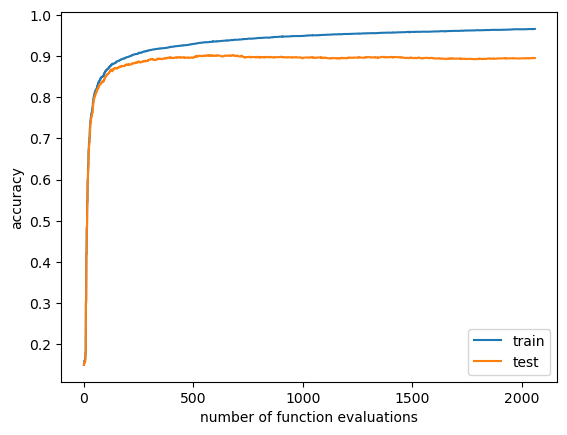

In [5]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.LBFGS(100),
        tz.m.RelativeWeightDecay(0.2),
        tz.m.Backtracking()
    ),
    num_steps=1000,
)

### 7. Testing other optimizers

Other notable algorithms are tested below. They did not beat L-BFGS by test loss and accuracy, but some of them achieved lower training loss.

#### 7.1 Adam

As a baseline let's try AdamW with a one cycle scheduler. I gave it 2000 steps as it takes roughtly the same time as 1000 L-BFGS steps, mainly due to each L-BFGS step performing multiple evaluations due to a line search. 

Adam requires tuning and maybe with appropriate hyperparameters it converges faster, but tuning requires a lot of time. For this I only tuned learning rate, weight decay and the scheduler choice.

  0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.1900, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 2000/2000 [07:04<00:00,  4.72it/s]

max(test_acc) = 0.8899999856948853
min(test_losses) = 0.32787472009658813


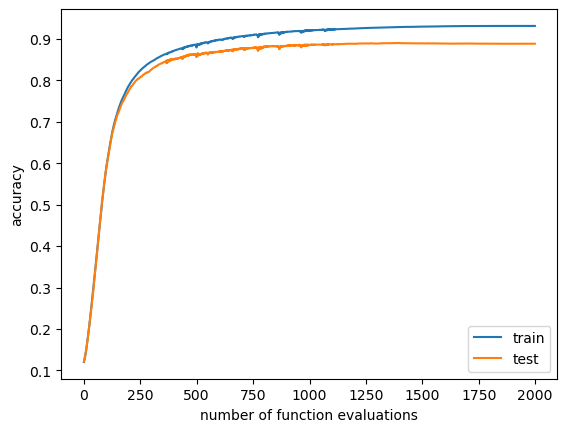

In [7]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.Adam(),
        tz.m.RelativeWeightDecay(0.2),
        tz.m.LR(1e-3)
    ),
    num_steps=2000,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, total_steps=2000, cycle_momentum=False)
)

#### 7.2 SOAP

SOAP converges to really low train loss, significantly outperforming even L-BFGS. However it overfits strongly and no amount of weight decay appears to help.

tensor(8.1953e-05, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 2000/2000 [07:29<00:00,  4.45it/s]

max(test_acc) = 0.8905999660491943
min(test_losses) = 0.32798296213150024


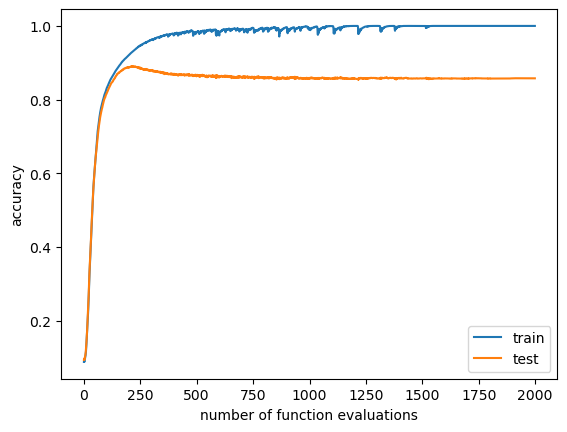

In [8]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.RelativeWeightDecay(0.2),
        tz.m.LR(1e-2)
    ),
    num_steps=2000,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, total_steps=2000, cycle_momentum=False)
)

#### 7.3 Muon

Muon can have similar performance to SOAP while requiring way less memory, especially as model size grows, but its a bit more complex to set up. Muon is recommended for large batch sizes, but in our full-batch case it achieves a very low train loss and overfits just like SOAP.

Muon is orthogonalization applied to momentum in an efficient way using Newton-Schulz iteration. In torchzero orthogonalization is implemented as ``Orthogonalize`` module.

Orthogonalization can only be applied to 2D+ layers, so some fallback optimizer is needed for 1D layers. Official implementation uses Adam with a 66 times smaller learning rate.

Authors suggest that embeddings, classifier heads, hidden gains/biases and first convolutional layer should be optimized using standard AdamW (although I don't really know why).

In torchzero parameters can be split by using the ``Split`` module, I will also add a more convenient way to split updates at some point.

Four our model the filter to skip head and 1st convolutional layer is ``lambda p: p.ndim >= 3 and p.shape != (16, 1, 3, 3)``. However both first convolutional layer and the head classifier appear to improve the losses when included in Muon update rule, so I didn't use the filter. That could be due to needing to tune fallback Adam learning rate, but that would just take too much time.

tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 2000/2000 [07:19<00:00,  4.55it/s]

max(test_acc) = 0.8854999542236328
min(test_losses) = 0.33867186307907104


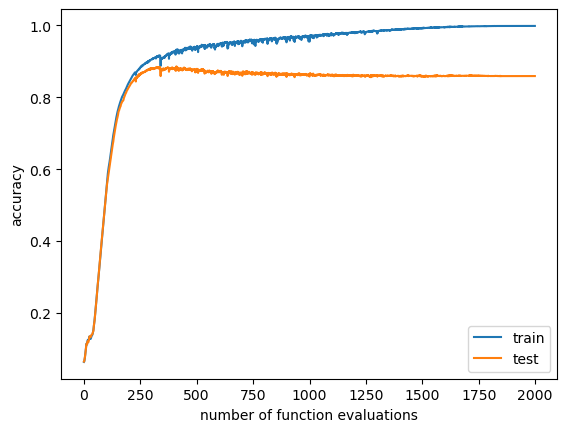

In [6]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        # same hyperparams as https://github.com/KellerJordan/Muon
        tz.m.NAG(0.95),
        tz.m.Split(
            lambda p: p.ndim >= 2,
            true = tz.m.Orthogonalize(),
            false = [tz.m.Adam(0.9, 0.95), tz.m.Mul(1/66)],
        ),
        tz.m.LR(1e-2),
    ),
    num_steps=2000,
    scheduler_fn = lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, total_steps=2000, cycle_momentum=False)
)

#### 7.4 PSGD

For completeness we have to also test PSGD, even though its not implemented in torchzero yet. I used implementation from [heavyball](https://github.com/HomebrewML/HeavyBall). The LRA-Newton version appears to work best and gets quite close to L-BFGS, but one step takes about twice as much time to compute (and also scales more with model size).

  0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 2000/2000 [09:05<00:00,  3.66it/s]

max(test_acc) = 0.8926999568939209
min(test_losses) = 0.3233204483985901


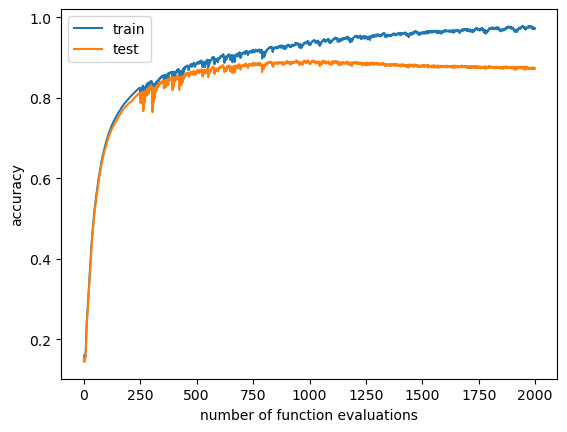

In [5]:
import heavyball

# torch.compile is really slow on my laptop :(
# fortunately on a tiny model it doesn't matter
heavyball.utils.compile_mode = None

model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: heavyball.NewtonPSGDLRA(list(params), lr=1e-3, rank=100, weight_decay=1e-2),
    num_steps=2000,
)

### 8. Should I use full-batch learning?

The 90% accuracy isn't bad for 10k model, however in the mini-batch notebook the same model achieves ? accuracy in less time. 

Still, if your datasets are very small or your model is very simple, full-batch may be faster and more rubust, and doesn't require tuning. This is particularly useful when routinely fitting many datasets, i.e. fitting a meta-model for hyper-parameter optimization, or fitting many models on feature subsets to extract feature importance.